# Extracción de datos

## Imports para extracción

In [2]:
import pandas as pd 
import numpy as np
import oandapy as opy
import psycopg2
import logging
import os
from datetime import datetime as dt
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

Extraemos datos de precios (Oanda) para el instrumento que elijamos y de twitter (Base de datos de Prophets)

### Oanda

In [3]:
pricediff = True # Precios o differencia de precios
logreturns = True # Diferencia en logaritmos de los precios
candleformat = 'midpoint' # ['midpoint', 'bidask']
instruments = ['USD_JPY', 
               'USB02Y_USD',
               'USB05Y_USD',
               'USB10Y_USD', 
               'USB30Y_USD',
               'UK100_GBP',
               'UK10YB_GBP',
               'JP225_USD',
               'HK33_HKD',
               'EU50_EUR',
               'DE30_EUR',
               'DE10YB_EUR',
               'WTICO_USD',
               'US30_USD',
               'SPX500_USD']
               
granularity = 'H1'
d1 = '2008-01-01'
min_window = 5
step = int(60/min_window)
d2 = str(dt.now())[:10]
oanda = opy.API(environment='live')

In [4]:
divs = {}

for j in instruments:
    print(j)
    # Extraemos datos cada 2 días (por simplicidad)
    d1 = '2008-01-01'
    d2 = str(dt.now())[:10]
    dates = pd.date_range(start=d1, end=d2, freq='15D')
    df = pd.DataFrame()

    print('Se van a descargar {} días'.format(10*len(dates)))
    print('Descargando:')

    pbar = tqdm(total=len(dates) - 1)

    for i in range(0, len(dates) - 1):
        # Oanda toma las fechas en este formato
        d1 = str(dates[i]).replace(' ', 'T')
        d2 = str(dates[i+1]).replace(' ', 'T')
        try:
            # Concatenamos cada día en el dataframe
            data = oanda.get_history(instrument=j, 
                                     candleFormat=candleformat,
                                     start=d1, 
                                     end=d2, 
                                     granularity=granularity)
            df = df.append(pd.DataFrame(data['candles']))
            pbar.update(1)
        except:
            pass
    pbar.close()
    date = pd.DatetimeIndex(df['time'], tz='UTC')
    df['date'] = date
    cols = [j + '_' + k for k in df.columns]
    df.columns = cols
    divs[j] = df

USD_JPY
Se van a descargar 2650 días
Descargando:


HBox(children=(IntProgress(value=0, max=264), HTML(value='')))


USB02Y_USD
Se van a descargar 2650 días
Descargando:


HBox(children=(IntProgress(value=0, max=264), HTML(value='')))


USB05Y_USD
Se van a descargar 2650 días
Descargando:


HBox(children=(IntProgress(value=0, max=264), HTML(value='')))


USB10Y_USD
Se van a descargar 2650 días
Descargando:


HBox(children=(IntProgress(value=0, max=264), HTML(value='')))


USB30Y_USD
Se van a descargar 2650 días
Descargando:


HBox(children=(IntProgress(value=0, max=264), HTML(value='')))


UK100_GBP
Se van a descargar 2650 días
Descargando:


HBox(children=(IntProgress(value=0, max=264), HTML(value='')))


UK10YB_GBP
Se van a descargar 2650 días
Descargando:


HBox(children=(IntProgress(value=0, max=264), HTML(value='')))


JP225_USD
Se van a descargar 2650 días
Descargando:


HBox(children=(IntProgress(value=0, max=264), HTML(value='')))


HK33_HKD
Se van a descargar 2650 días
Descargando:


HBox(children=(IntProgress(value=0, max=264), HTML(value='')))


EU50_EUR
Se van a descargar 2650 días
Descargando:


HBox(children=(IntProgress(value=0, max=264), HTML(value='')))


DE30_EUR
Se van a descargar 2650 días
Descargando:


HBox(children=(IntProgress(value=0, max=264), HTML(value='')))


DE10YB_EUR
Se van a descargar 2650 días
Descargando:


HBox(children=(IntProgress(value=0, max=264), HTML(value='')))


WTICO_USD
Se van a descargar 2650 días
Descargando:


HBox(children=(IntProgress(value=0, max=264), HTML(value='')))


US30_USD
Se van a descargar 2650 días
Descargando:


HBox(children=(IntProgress(value=0, max=264), HTML(value='')))


SPX500_USD
Se van a descargar 2650 días
Descargando:


HBox(children=(IntProgress(value=0, max=264), HTML(value='')))

In [12]:
df = divs[instruments[0]]
for i in instruments[1:]:
    join_id = [k for k in divs[i].columns if 'date' in k][0]
    df = pd.merge(df, divs[i], left_on='USD_JPY_date', right_on=join_id, how='left')

In [25]:
date = 'USD_JPY_date'

In [21]:
drops = [k for k in df.columns if date not in k and ('date' in k or 'complete' in k or 'time' in k)]
df = df.drop(drops, axis=1)
df = df[100:] # Falla en API
df = df.reset_index(drop=True)

In [23]:
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')

In [ ]:
if candleformat == 'bidask':
    
    if pricediff:
        
        prices = [j for j in df.columns if j not in ['date', 'volume']]
        
        if logreturns:
            for i in prices:
                df['diff ' + i] = np.log(df[i]).diff(1)
        
        else:
            
            for i in prices:
                df['diff ' + i] = df[i] - df[i].shift(1)
        df = df.drop(prices, axis=1)

        open_bid = ['diff openBid' + str(min_window*(i+1)) for i in range(step)]
        open_ask = ['diff openAsk' + str(min_window*(i+1)) for i in range(step)]
        close_bid = ['diff closeBid' + str(min_window*(i+1)) for i in range(step)]
        close_ask = ['diff closeAsk' + str(min_window*(i+1)) for i in range(step)]
        low_bid = ['diff lowBid' + str(min_window*(i+1)) for i in range(step)]
        low_ask = ['diff lowAsk' + str(min_window*(i+1)) for i in range(step)]
        high_bid = ['diff highBid' + str(min_window*(i+1)) for i in range(step)]
        high_ask = ['diff highAsk' + str(min_window*(i+1)) for i in range(step)]
        volume = ['volume' + str(min_window*(i+1)) for i in range(step)]

        shifts = list(range(1,step+1))

        for v, ob, oa, cb, ca, lb, la, hb, ha, s in zip(volume,
                                                     open_bid, 
                                                     open_ask, 
                                                     close_bid, 
                                                     close_ask, 
                                                     low_bid, 
                                                     low_ask, 
                                                     high_bid, 
                                                     high_ask, 
                                                     shifts):
            df[v] = df['volume'].shift(s)
            df[ob] = df['diff openBid'].shift(s)
            df[oa] = df['diff openAsk'].shift(s)
            df[cb] = df['diff closeBid'].shift(s)
            df[ca] = df['diff closeAsk'].shift(s)
            df[lb] = df['diff lowBid'].shift(s)
            df[la] = df['diff lowAsk'].shift(s)
            df[hb] = df['diff highBid'].shift(s)
            df[ha] = df['diff highAsk'].shift(s)

    else:

        open_bid = ['openBid' + str(min_window*(i+1)) for i in range(step)]
        open_ask = ['openAsk' + str(min_window*(i+1)) for i in range(step)]
        close_bid = ['closeBid' + str(min_window*(i+1)) for i in range(step)]
        close_ask = ['closeAsk' + str(min_window*(i+1)) for i in range(step)]
        low_bid = ['lowBid' + str(min_window*(i+1)) for i in range(step)]
        low_ask = ['lowAsk' + str(min_window*(i+1)) for i in range(step)]
        high_bid = ['highBid' + str(min_window*(i+1)) for i in range(step)]
        high_ask = ['highAsk' + str(min_window*(i+1)) for i in range(step)]
        volume = ['volume' + str(min_window*(i+1)) for i in range(step)]

        shifts = list(range(1,step+1))

        for v, ob, oa, cb, ca, lb, la, hb, ha, s in zip(volume,
                                                     open_bid, 
                                                     open_ask, 
                                                     close_bid, 
                                                     close_ask, 
                                                     low_bid, 
                                                     low_ask, 
                                                     high_bid, 
                                                     high_ask, 
                                                     shifts):
            df[v] = df['volume'].shift(s)
            df[ob] = df['openBid'].shift(s)
            df[oa] = df['openAsk'].shift(s)
            df[cb] = df['closeBid'].shift(s)
            df[ca] = df['closeAsk'].shift(s)
            df[lb] = df['lowBid'].shift(s)
            df[la] = df['lowAsk'].shift(s)
            df[hb] = df['highBid'].shift(s)
            df[ha] = df['highAsk'].shift(s)
else:  
    
    if pricediff:

        prices = [j for j in df.columns if j not in ['date', 'volume']]
        
        if logreturns:
            for i in prices:
                df['diff ' + i] = np.log(df[i]).diff(1)
        
        else:
            
            for i in prices:
                df['diff ' + i] = df[i] - df[i].shift(1)
                
        df = df.drop(prices, axis=1)

        open_ = ['diff openMid' + str(min_window*(i+1)) for i in range(step)]
        close = ['diff closeMid' + str(min_window*(i+1)) for i in range(step)]
        low = ['diff lowMid' + str(min_window*(i+1)) for i in range(step)]
        high = ['diff highMid' + str(min_window*(i+1)) for i in range(step)]
        volume = ['volume' + str(min_window*(i+1)) for i in range(step)]

        shifts = list(range(1,step+1))

        for v, o, c, l, h, s in zip(volume,
                                     open_, 
                                     close, 
                                     low, 
                                     high, 
                                     shifts):
            df[v] = df['volume'].shift(s)
            df[o] = df['diff openMid'].shift(s)
            df[c] = df['diff closeMid'].shift(s)
            df[l] = df['diff lowMid'].shift(s)
            df[h] = df['diff highMid'].shift(s)

    else:

        open_ = ['openMid' + str(min_window*(i+1)) for i in range(step)]
        close = ['closeMid' + str(min_window*(i+1)) for i in range(step)]
        low = ['lowMid' + str(min_window*(i+1)) for i in range(step)]
        high = ['highMid' + str(min_window*(i+1)) for i in range(step)]
        volume = ['volume' + str(min_window*(i+1)) for i in range(step)]

        shifts = list(range(1,step+1))

        for v, o, c, l, h, s in zip(volume,
                                     open_, 
                                     close, 
                                     low, 
                                     high, 
                                     shifts):
            df[v] = df['volume'].shift(s)
            df[o] = df['openMid'].shift(s)
            df[c] = df['closeMid'].shift(s)
            df[l] = df['lowMid'].shift(s)
            df[h] = df['highMid'].shift(s)


In [ ]:
df = df[step+1:]

In [26]:
df[date] = df[date].astype(str)
df['d2'] = df[date].str[14:]
df = df[df['d2'] == '00:00+00:00']

In [27]:
df = df.reset_index(drop=True)
df = df.drop('d2', axis=1)

In [ ]:
fake_drop = volume + ['volume', 'date']
df['H'] = df.drop(fake_drop, 1).max(axis=1)
df['L'] = df.drop(fake_drop, 1).min(axis=1)
df['vol'] = df[volume].sum(axis=1)

In [29]:
df[date] = df[date].str[:13]
pr = df.copy()

### Twitter

In [31]:
def db_conn():
    """
    Método que hace la conexión a la base de datos
    Args:
        conn_creds(dict): diccionario donde vienen las credenciales de
        la conexión a la base de datos
                         host(str): host que hospeda a la base de datos
                         port(str): puerto donde está disponible la base de datos
                         user(str): usuario con el que se hará la conexión
                         password(str): contraseña del usuario en la BD
                         database(str): nombre de la base de datos
    Returns:
        conn: objeto que contiene la sesión de una conexión a la BD
    """
    try:
        conn = psycopg2.connect(
            host=os.environ['ID_HOST'],
            port=os.environ['ID_PORT'],
            user=os.environ['ID_USER'],
            password=os.environ['ID_PASSWORD'],
            database=os.environ['ID_DB'],
        )
    except Exception as error:
        logging.error(error)

    return conn

def download(conn, query):
    """
    Descarga datos de la base de datos según la consulta insertada
    Args:
        conn (connection): objeto que contiene la sesión de una
                           conexión a la base de datos
        query (str): String donde se define el query a ejecutarse
    Returns:
        df (DataFrame): Tabla con los datos que elegimos
    """
    try:
        df = pd.read_sql(query, conn)
        conn.commit()
    finally:
        conn.close()


    return df

In [32]:
conn = db_conn()
query = '''SELECT date_trunc('hour',cast(date as timestamp)), avg(polarity) polarity, avg(subjectivity) subjectivity
           FROM tweets 
           WHERE
           tweet like '%inflation%' OR
            tweet like '%dollar%' OR
            tweet like '%FED%' OR 
            tweet like '%rates%' OR
            tweet like '%usd%' OR
            tweet like '%usdjpy%' OR
            tweet like '%yen%' OR
            tweet like '%markets' OR
            tweet like '%forex%' OR
            tweet like '%fx%' OR
            tweet like '%China%' OR
            tweet like '%tradewar%' OR
            tweet like '%trade%' OR
            tweet like '%business%' OR
            tweet like '%economy%' OR
            tweet like '%Dow%' OR
            tweet like '%Nasdaq%' OR 
            tweet like '%Russia%' OR
            tweet like '%BOJ%' OR
            tweet like '%central bank%' OR
            tweet like '%economic calendar%' OR
            tweet like '%U.S.%' OR
            tweet like '%Brexit%' OR
            tweet like '%pound%' OR
            tweet like '%gains%' OR
            tweet like '%bearish%' OR
            tweet like '%bullish%' OR
            tweet like '%forecast%' OR
            tweet like '%Donald%' OR
            tweet like '%Trump%' OR
            tweet like '%fixed income%' OR
            tweet like '%capital%' OR
            tweet like '%Wall Street%' OR
            tweet like '%debt%' OR
            tweet like '%EU%' OR
            tweet like '%reshaping%' OR
            tweet like '%condifence%' OR
            tweet like '%indicator%' OR
            tweet like '%indicators%' OR
            tweet like '%policies%' OR
            tweet like '%gold%' OR
            tweet like '%commodities%' OR
            tweet like '%technical%' OR
            tweet like '%canadian%' OR
            tweet like '%unemployment%' OR
            tweet like '%ISM%' OR
            tweet like '%housing%' OR
            tweet like '%bubble%' OR
            tweet like '%recession%' OR
            tweet like '%PMI%' OR
            tweet like '%oil%' OR
            tweet like '%jobs%' OR
            tweet like '%yield%' OR
            tweet like '%crude%' OR
            tweet like '%ECB%' OR
            tweet like '%jobless%' OR
            tweet like '%FOMC%' OR
            tweet like '%GDP%' OR
            tweet like '%manufacturing%' OR
            tweet like '%PPI%' OR
            tweet like '%Industrial%' OR
            tweet like '%CPI%' OR
            tweet like '%Core CPI%' OR
            tweet like '%employment%' OR
            tweet like '%retail%' OR
            tweet like '%index%' 
        
GROUP BY date_trunc('hour',cast(date as timestamp)) 
order by date_trunc DESC'''
tw = download(conn, query)

In [33]:
tw['date_trunc'] = tw['date_trunc'] + timedelta(hours=5)
tw['date_trunc'] = tw['date_trunc'].astype(str)
tw['date_trunc'] = tw['date_trunc'].str[:13]

In [34]:
df = pd.merge(pr, tw, left_on=date, right_on='date_trunc', how='left')
df = df.drop([date, 'date_trunc'], axis=1)

In [35]:
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')

### VIF

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif(X):
    """
    Nos da el factor de inflación de la varianza de cada variable independiente

    Args:
        X (DataFrame): DataFrame con datos de nuestras variables independientes
    Returns:
        vif (DataFrame): DataFrame con el factor de inflación de la varianza
                         de cada variable
    """
    vif = pd.DataFrame()
    X['intercept'] = 1
    x = X.values
    vif['vif'] = [variance_inflation_factor(x, i) for i in range(x.shape[1])]
    vif['feature'] = X.columns

    return vif

In [37]:
DF = df.copy()

In [ ]:
df = DF.copy()

In [39]:
if pricediff:
    
    prices = [j for j in df.columns if j not in ['polarity', 'subjectivity']]

    if logreturns:
        for i in prices:
            df['diff ' + i] = np.log(df[i]).diff(1)

    else:

        for i in prices:
            df['diff ' + i] = df[i] - df[i].shift(1)

    df = df.drop(prices, axis=1)

In [42]:
df = df.dropna()

In [43]:
if pricediff:
    dontdrop = ['diff USD_JPY_closeMid', 'diff USD_JPY_highMid', 'diff USD_JPY_lowMid']
else:
    dontdrop = ['USD_JPY_closeMid', 'USD_JPY_highMid', 'USD_JPY_lowMid']
    
dropping = [1, 2]

while len(dropping) >= 2:
    
    vif = get_vif(df)
    svif = vif.sort_values('vif').reset_index(drop=True)
    display(svif)
    dropping = svif[svif['vif'] >= 100]
    try:
        vif_drops = list(dropping.sample(n=int(len(dropping)/2))['feature'].values)
        vif_drops = [i for i in vif_drops if i not in dontdrop]
        df = df.drop(vif_drops, axis=1)   
    except:
        display(svif)
     

/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,vif,feature
0,1.043998,polarity
1,1.047110,subjectivity
2,1.291674,diff HK33_HKD_volume
3,1.353443,diff USB02Y_USD_volume
4,1.452605,diff USD_JPY_volume
5,1.863307,diff UK100_GBP_volume
6,1.868380,diff JP225_USD_volume
7,1.942095,diff DE30_EUR_volume
8,2.025619,diff WTICO_USD_volume
9,2.078221,diff DE10YB_EUR_volume


,vif,feature
0,1.043998,polarity
1,1.047110,subjectivity
2,1.291674,diff HK33_HKD_volume
3,1.353443,diff USB02Y_USD_volume
4,1.452605,diff USD_JPY_volume
5,1.863307,diff UK100_GBP_volume
6,1.868380,diff JP225_USD_volume
7,1.942095,diff DE30_EUR_volume
8,2.025619,diff WTICO_USD_volume
9,2.078221,diff DE10YB_EUR_volume


In [44]:
df.head()

,polarity,subjectivity,diff USD_JPY_closeMid,diff USD_JPY_highMid,diff USD_JPY_lowMid,diff USD_JPY_openMid,diff USD_JPY_volume,diff USB02Y_USD_closeMid,diff USB02Y_USD_highMid,diff USB02Y_USD_lowMid,diff USB02Y_USD_openMid,diff USB02Y_USD_volume,diff USB05Y_USD_closeMid,diff USB05Y_USD_highMid,diff USB05Y_USD_lowMid,diff USB05Y_USD_openMid,diff USB05Y_USD_volume,diff USB10Y_USD_closeMid,diff USB10Y_USD_highMid,diff USB10Y_USD_lowMid,diff USB10Y_USD_openMid,diff USB10Y_USD_volume,diff USB30Y_USD_closeMid,diff USB30Y_USD_highMid,diff USB30Y_USD_lowMid,diff USB30Y_USD_openMid,diff USB30Y_USD_volume,diff UK100_GBP_closeMid,diff UK100_GBP_highMid,diff UK100_GBP_lowMid,diff UK100_GBP_openMid,diff UK100_GBP_volume,diff UK10YB_GBP_closeMid,diff UK10YB_GBP_highMid,diff UK10YB_GBP_lowMid,diff UK10YB_GBP_openMid,diff UK10YB_GBP_volume,diff JP225_USD_closeMid,diff JP225_USD_highMid,diff JP225_USD_lowMid,diff JP225_USD_openMid,diff JP225_USD_volume,diff HK33_HKD_closeMid,diff HK33_HKD_highMid,diff HK33_HKD_lowMid,diff HK33_HKD_openMid,diff HK33_HKD_volume,diff EU50_EUR_closeMid,diff EU50_EUR_highMid,diff EU50_EUR_lowMid,diff EU50_EUR_openMid,diff EU50_EUR_volume,diff DE30_EUR_closeMid,diff DE30_EUR_highMid,diff DE30_EUR_lowMid,diff DE30_EUR_openMid,diff DE30_EUR_volume,diff DE10YB_EUR_closeMid,diff DE10YB_EUR_highMid,diff DE10YB_EUR_lowMid,diff DE10YB_EUR_openMid,diff DE10YB_EUR_volume,diff WTICO_USD_closeMid,diff WTICO_USD_highMid,diff WTICO_USD_lowMid,diff WTICO_USD_openMid,diff WTICO_USD_volume,diff US30_USD_closeMid,diff US30_USD_highMid,diff US30_USD_lowMid,diff US30_USD_openMid,diff US30_USD_volume,diff SPX500_USD_closeMid,diff SPX500_USD_highMid,diff SPX500_USD_lowMid,diff SPX500_USD_openMid,diff SPX500_USD_volume,intercept
1,-0.183333,0.866667,-0.000596,-0.000174,-0.000275,-0.000009,0.204771,0.000000,0.000142,0.000303,0.000293,0.015267,0.000421,0.000143,0.000278,0.000421,-0.197064,0.000536,0.000407,0.000676,0.000537,-0.016000,0.000795,0.000524,0.001059,0.001320,0.250099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001053,-0.004139,-0.003123,-0.004826,0.279839,0.0,0.0,0.0,0.0,0.0,-0.003031,-0.003307,-0.003867,-0.004144,-0.510826,-0.001266,-0.001889,-0.002216,-0.002145,-0.007526,0.000436,0.000087,-0.000078,0.000087,-0.199333,0.002420,-0.001888,-0.001162,-0.004624,0.070734,-0.002644,-0.003794,-0.004053,-0.003875,0.216364,-0.003115,-0.004088,-0.005111,-0.004724,0.251827,1
2,-0.183333,0.866667,0.000138,-0.000651,-0.000367,-0.000697,-0.202228,0.000076,0.000076,0.000142,0.000151,-0.526093,0.000000,0.000421,0.000564,0.000421,-0.366625,0.000000,0.000536,0.000943,0.000545,-0.550584,0.000000,0.000532,0.001582,0.000795,-1.052866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000700,0.002052,0.000688,-0.001045,0.173093,0.0,0.0,0.0,0.0,0.0,0.001947,0.001391,-0.001395,-0.001395,0.287682,0.002033,0.000766,-0.001078,-0.001266,0.039802,-0.000078,0.000522,0.000349,0.000261,0.385662,0.000840,0.000525,0.006009,0.002630,-2.903046,0.004353,0.002565,-0.000471,-0.002800,0.042616,0.003822,0.001623,-0.001424,-0.003186,0.042493,1
3,-0.183333,0.866667,0.001054,0.001832,0.001285,0.000147,-0.898981,0.000076,-0.000066,0.000076,-0.000076,-1.098612,0.000000,-0.000286,0.000134,-0.000009,-1.609438,0.000000,-0.000406,-0.000130,-0.000009,-0.743337,-0.000271,-0.000794,-0.000524,-0.000532,-0.851371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002417,-0.001035,0.001035,-0.001733,-1.685075,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001049,0.003143,0.000840,0.000525,0.219054,-0.001467,-0.000304,0.005853,0.004510,-1.777520,-0.001202,-0.000353,0.006889,0.004034,-1.482368,1
4,-0.183333,0.866667,0.000595,-0.000183,0.000092,0.001008,-0.565876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000

# Modelos

## Imports para modelos

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tpot import TPOTClassifier, TPOTRegressor
from sklearn.metrics import mean_squared_error

/home/usuario-rtd/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [46]:
def train_test(df, response, train_size=0.75, time_series=False, scaling=None):
    """
    Regresa train y test sets

    Args:
        df (DataFrame): Datos listos para el modelo
        response (str): Variable respuesta
        train_size (float): % Train Size
        time_series (boolean): Si es serie de tiempo o no
        scaling (str): ['standard', 'minmax', 'maxabs', 'robust', 'quantile']
    Returns:
        X_train (Array): conjunto de datos de entrenamiento (indep)
        X_test (Array): conjunto de datos de prueba (indep)
        y_train (Array): conjunto de datos de entrenamiento (dep)
        y_test (Array): conjunto de datos de prueba (dep)
    """

    data = df.copy()
    X = data.drop(response, 1)
    y = data[response]

    logging.info('X columns')
    logging.info(list(X.columns))
    logging.info('Response')
    logging.info(response)

    if time_series:
        trainsize = int(train_size*len(X))
        X_train = X[:trainsize].values
        X_test = X[trainsize:].values
        y_train = y[:trainsize].values
        y_test = y[trainsize:].values

    else:
        X_train, X_test, y_train, y_test = train_test_split(X.values,
                                                            y.values,
                                                            random_state=0,
                                                            train_size=train_size)
    if scaling == 'standard':
        scaler = preprocessing.StandardScaler()
    if scaling == 'minmax':
        scaler = preprocessing.MinMaxScaler()
    if scaling == 'maxabs':
        scaler = preprocessing.MaxAbsScaler()
    if scaling == 'robust':
        scaler = preprocessing.RobustScaler()
    if scaling == 'quantile':
        scaler = preprocessing.QuantileTransformer()

    if scaling != None:
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

def tpotclass(X_train, y_train):
    """
    Usando TPOT (Tree-Based Pipeline Optimization Tool), librería de AutoML,
    genera el "mejor" modelo de clasificación automáticamente
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        tpotmod (modelo): Modelo de clasificación generado con TPOT
    """
    pipeline_optimizer = TPOTClassifier(generations=5,
                                        population_size=50,
                                        cv=5,
                                        random_state=42,
                                        verbosity=2,
                                        n_jobs=4)
    tpotmod = pipeline_optimizer.fit(X_train, y_train)

    return tpotmod

def tpotreg(X_train, y_train):
    """
    Usando TPOT (Tree-Based Pipeline Optimization Tool), librería de AutoML,
    genera el "mejor" modelo de regresión automáticamente
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        tpotmod (modelo): Modelo de regresión generado con TPOT
    """

    pipeline_optimizer = TPOTRegressor(generations=5,
                                       population_size=50,
                                       cv=5,
                                       random_state=42,
                                       verbosity=2,
                                       n_jobs=4)
    tpotmod = pipeline_optimizer.fit(X_train, y_train)

    return tpotmod

def logreg(X_train, y_train):
    """
    Calcula modelo de Regresión Logística
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        logreg (modelo): Regresión Logística
    """
    try:
        # Si la matriz es singular va a dar error
        log = sm.Logit(y_train, X_train)
        logreg_model = log.fit()
    except Exception as e:
        # Intentamos con la matriz hessiana
        print(e)
        log = sm.Logit(y_train, X_train)
        logreg_model = log.fit(method='bfgs')

    return logreg_model

def linreg(X_train, y_train):
    """
    Calcula modelo de Regresión Lineal
    Args:
        X_train (Array): conjunto de datos de entrenamiento (regresores)
        y_train (Array): conjunto de datos de entrenamiento (objetivo)
    Returns:
        linreg_model (modelo): Regresión Lineal
    """
    linreg = sm.OLS(y_train, X_train)
    linreg_model = linreg.fit()

    return linreg_model

#### Creación de modelos

In [47]:
DF = df.copy()

,polarity,subjectivity,diff USD_JPY_closeMid,diff USD_JPY_highMid,diff USD_JPY_lowMid,diff USD_JPY_openMid,diff USD_JPY_volume,diff USB02Y_USD_closeMid,diff USB02Y_USD_highMid,diff USB02Y_USD_lowMid,diff USB02Y_USD_openMid,diff USB02Y_USD_volume,diff USB05Y_USD_closeMid,diff USB05Y_USD_highMid,diff USB05Y_USD_lowMid,diff USB05Y_USD_openMid,diff USB05Y_USD_volume,diff USB10Y_USD_closeMid,diff USB10Y_USD_highMid,diff USB10Y_USD_lowMid,diff USB10Y_USD_openMid,diff USB10Y_USD_volume,diff USB30Y_USD_closeMid,diff USB30Y_USD_highMid,diff USB30Y_USD_lowMid,diff USB30Y_USD_openMid,diff USB30Y_USD_volume,diff UK100_GBP_closeMid,diff UK100_GBP_highMid,diff UK100_GBP_lowMid,diff UK100_GBP_openMid,diff UK100_GBP_volume,diff UK10YB_GBP_closeMid,diff UK10YB_GBP_highMid,diff UK10YB_GBP_lowMid,diff UK10YB_GBP_openMid,diff UK10YB_GBP_volume,diff JP225_USD_closeMid,diff JP225_USD_highMid,diff JP225_USD_lowMid,diff JP225_USD_openMid,diff JP225_USD_volume,diff HK33_HKD_closeMid,diff HK33_HKD_highMid,diff HK33_HKD_lowMid,diff HK33_HKD_openMid,diff HK33_HKD_volume,diff EU50_EUR_closeMid,diff EU50_EUR_highMid,diff EU50_EUR_lowMid,diff EU50_EUR_openMid,diff EU50_EUR_volume,diff DE30_EUR_closeMid,diff DE30_EUR_highMid,diff DE30_EUR_lowMid,diff DE30_EUR_openMid,diff DE30_EUR_volume,diff DE10YB_EUR_closeMid,diff DE10YB_EUR_highMid,diff DE10YB_EUR_lowMid,diff DE10YB_EUR_openMid,diff DE10YB_EUR_volume,diff WTICO_USD_closeMid,diff WTICO_USD_highMid,diff WTICO_USD_lowMid,diff WTICO_USD_openMid,diff WTICO_USD_volume,diff US30_USD_closeMid,diff US30_USD_highMid,diff US30_USD_lowMid,diff US30_USD_openMid,diff US30_USD_volume,diff SPX500_USD_closeMid,diff SPX500_USD_highMid,diff SPX500_USD_lowMid,diff SPX500_USD_openMid,diff SPX500_USD_volume,intercept,future diff close
1,-0.183333,0.866667,-0.000596,-0.000174,-0.000275,-0.000009,0.204771,0.000000,0.000142,0.000303,0.000293,0.015267,0.000421,0.000143,0.000278,0.000421,-0.197064,0.000536,0.000407,0.000676,0.000537,-0.016000,0.000795,0.000524,0.001059,0.001320,0.250099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001053,-0.004139,-0.003123,-0.004826,0.279839,0.0,0.0,0.0,0.0,0.0,-0.003031,-0.003307,-0.003867,-0.004144,-0.510826,-0.001266,-0.001889,-0.002216,-0.002145,-0.007526,0.000436,0.000087,-0.000078,0.000087,-0.199333,0.002420,-0.001888,-0.001162,-0.004624,0.070734,-0.002644,-0.003794,-0.004053,-0.003875,0.216364,-0.003115,-0.004088,-0.005111,-0.004724,0.251827,1,0.000138
2,-0.183333,0.866667,0.000138,-0.000651,-0.000367,-0.000697,-0.202228,0.000076,0.000076,0.000142,0.000151,-0.526093,0.000000,0.000421,0.000564,0.000421,-0.366625,0.000000,0.000536,0.000943,0.000545,-0.550584,0.000000,0.000532,0.001582,0.000795,-1.052866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000700,0.002052,0.000688,-0.001045,0.173093,0.0,0.0,0.0,0.0,0.0,0.001947,0.001391,-0.001395,-0.001395,0.287682,0.002033,0.000766,-0.001078,-0.001266,0.039802,-0.000078,0.000522,0.000349,0.000261,0.385662,0.000840,0.000525,0.006009,0.002630,-2.903046,0.004353,0.002565,-0.000471,-0.002800,0.042616,0.003822,0.001623,-0.001424,-0.003186,0.042493,1,0.001054
3,-0.183333,0.866667,0.001054,0.001832,0.001285,0.000147,-0.898981,0.000076,-0.000066,0.000076,-0.000076,-1.098612,0.000000,-0.000286,0.000134,-0.000009,-1.609438,0.000000,-0.000406,-0.000130,-0.000009,-0.743337,-0.000271,-0.000794,-0.000524,-0.000532,-0.851371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002417,-0.001035,0.001035,-0.001733,-1.685075,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001049,0.003143,0.000840,0.000525,0.219054,-0.001467,-0.000304,0.005853,0.004510,-1.777520,-0.001202,-0.000353,0.006889,0.004034,-1.482368,1,0.000595
4,-0.183333,0.866667,0.000595,-0.000183,0.000092,0.001008,-0.565876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,

,future diff close
diff USB02Y_USD_closeMid,-0.028465
diff USB05Y_USD_closeMid,-0.028433
diff USB10Y_USD_closeMid,-0.023810
diff USB05Y_USD_highMid,-0.018385
diff USB10Y_USD_highMid,-0.017417
diff USD_JPY_openMid,-0.016513
diff USB30Y_USD_highMid,-0.015571
diff USB30Y_USD_closeMid,-0.015531
diff USB05Y_USD_lowMid,-0.014928
diff US30_USD_volume,-0.014211


MSE
1.504333666312516e-06
diff USD_JPY_closeMid
LINREG


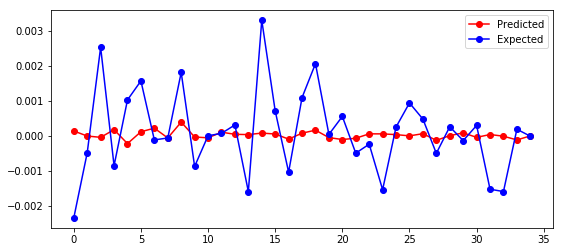

SVR


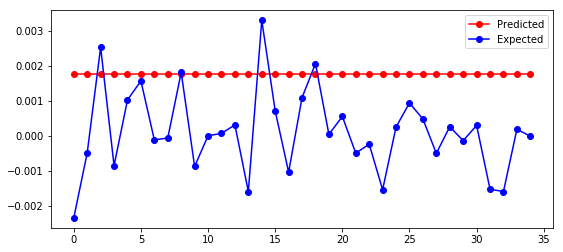

,polarity,subjectivity,diff USD_JPY_closeMid,diff USD_JPY_highMid,diff USD_JPY_lowMid,diff USD_JPY_openMid,diff USD_JPY_volume,diff USB02Y_USD_closeMid,diff USB02Y_USD_highMid,diff USB02Y_USD_lowMid,diff USB02Y_USD_openMid,diff USB02Y_USD_volume,diff USB05Y_USD_closeMid,diff USB05Y_USD_highMid,diff USB05Y_USD_lowMid,diff USB05Y_USD_openMid,diff USB05Y_USD_volume,diff USB10Y_USD_closeMid,diff USB10Y_USD_highMid,diff USB10Y_USD_lowMid,diff USB10Y_USD_openMid,diff USB10Y_USD_volume,diff USB30Y_USD_closeMid,diff USB30Y_USD_highMid,diff USB30Y_USD_lowMid,diff USB30Y_USD_openMid,diff USB30Y_USD_volume,diff UK100_GBP_closeMid,diff UK100_GBP_highMid,diff UK100_GBP_lowMid,diff UK100_GBP_openMid,diff UK100_GBP_volume,diff UK10YB_GBP_closeMid,diff UK10YB_GBP_highMid,diff UK10YB_GBP_lowMid,diff UK10YB_GBP_openMid,diff UK10YB_GBP_volume,diff JP225_USD_closeMid,diff JP225_USD_highMid,diff JP225_USD_lowMid,diff JP225_USD_openMid,diff JP225_USD_volume,diff HK33_HKD_closeMid,diff HK33_HKD_highMid,diff HK33_HKD_lowMid,diff HK33_HKD_openMid,diff HK33_HKD_volume,diff EU50_EUR_closeMid,diff EU50_EUR_highMid,diff EU50_EUR_lowMid,diff EU50_EUR_openMid,diff EU50_EUR_volume,diff DE30_EUR_closeMid,diff DE30_EUR_highMid,diff DE30_EUR_lowMid,diff DE30_EUR_openMid,diff DE30_EUR_volume,diff DE10YB_EUR_closeMid,diff DE10YB_EUR_highMid,diff DE10YB_EUR_lowMid,diff DE10YB_EUR_openMid,diff DE10YB_EUR_volume,diff WTICO_USD_closeMid,diff WTICO_USD_highMid,diff WTICO_USD_lowMid,diff WTICO_USD_openMid,diff WTICO_USD_volume,diff US30_USD_closeMid,diff US30_USD_highMid,diff US30_USD_lowMid,diff US30_USD_openMid,diff US30_USD_volume,diff SPX500_USD_closeMid,diff SPX500_USD_highMid,diff SPX500_USD_lowMid,diff SPX500_USD_openMid,diff SPX500_USD_volume,intercept,future diff high
1,-0.183333,0.866667,-0.000596,-0.000174,-0.000275,-0.000009,0.204771,0.000000,0.000142,0.000303,0.000293,0.015267,0.000421,0.000143,0.000278,0.000421,-0.197064,0.000536,0.000407,0.000676,0.000537,-0.016000,0.000795,0.000524,0.001059,0.001320,0.250099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001053,-0.004139,-0.003123,-0.004826,0.279839,0.0,0.0,0.0,0.0,0.0,-0.003031,-0.003307,-0.003867,-0.004144,-0.510826,-0.001266,-0.001889,-0.002216,-0.002145,-0.007526,0.000436,0.000087,-0.000078,0.000087,-0.199333,0.002420,-0.001888,-0.001162,-0.004624,0.070734,-0.002644,-0.003794,-0.004053,-0.003875,0.216364,-0.003115,-0.004088,-0.005111,-0.004724,0.251827,1,-0.000651
2,-0.183333,0.866667,0.000138,-0.000651,-0.000367,-0.000697,-0.202228,0.000076,0.000076,0.000142,0.000151,-0.526093,0.000000,0.000421,0.000564,0.000421,-0.366625,0.000000,0.000536,0.000943,0.000545,-0.550584,0.000000,0.000532,0.001582,0.000795,-1.052866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000700,0.002052,0.000688,-0.001045,0.173093,0.0,0.0,0.0,0.0,0.0,0.001947,0.001391,-0.001395,-0.001395,0.287682,0.002033,0.000766,-0.001078,-0.001266,0.039802,-0.000078,0.000522,0.000349,0.000261,0.385662,0.000840,0.000525,0.006009,0.002630,-2.903046,0.004353,0.002565,-0.000471,-0.002800,0.042616,0.003822,0.001623,-0.001424,-0.003186,0.042493,1,0.001832
3,-0.183333,0.866667,0.001054,0.001832,0.001285,0.000147,-0.898981,0.000076,-0.000066,0.000076,-0.000076,-1.098612,0.000000,-0.000286,0.000134,-0.000009,-1.609438,0.000000,-0.000406,-0.000130,-0.000009,-0.743337,-0.000271,-0.000794,-0.000524,-0.000532,-0.851371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002417,-0.001035,0.001035,-0.001733,-1.685075,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001049,0.003143,0.000840,0.000525,0.219054,-0.001467,-0.000304,0.005853,0.004510,-1.777520,-0.001202,-0.000353,0.006889,0.004034,-1.482368,1,-0.000183
4,-0.183333,0.866667,0.000595,-0.000183,0.000092,0.001008,-0.565876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0

,future diff high
diff USB10Y_USD_closeMid,-0.242461
diff USB05Y_USD_closeMid,-0.239889
diff USB30Y_USD_closeMid,-0.217313
diff USB02Y_USD_closeMid,-0.206349
diff USB10Y_USD_highMid,-0.164260
diff USB05Y_USD_highMid,-0.158014
diff USB30Y_USD_highMid,-0.146390
diff DE10YB_EUR_closeMid,-0.145321
diff USB02Y_USD_highMid,-0.139693
diff UK10YB_GBP_closeMid,-0.110625


MSE
8.047299154977623e-07
diff USD_JPY_highMid
LINREG


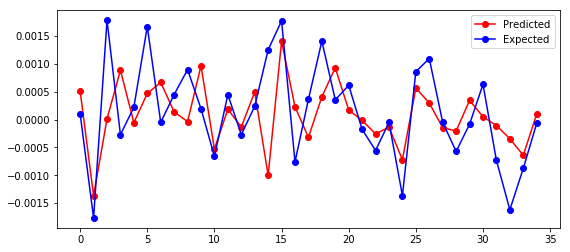

SVR


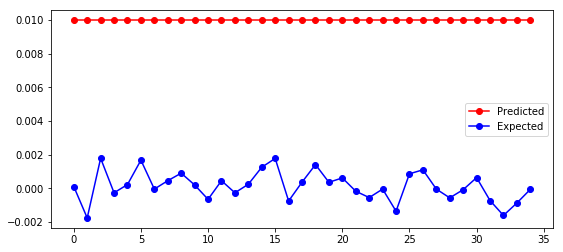

,polarity,subjectivity,diff USD_JPY_closeMid,diff USD_JPY_highMid,diff USD_JPY_lowMid,diff USD_JPY_openMid,diff USD_JPY_volume,diff USB02Y_USD_closeMid,diff USB02Y_USD_highMid,diff USB02Y_USD_lowMid,diff USB02Y_USD_openMid,diff USB02Y_USD_volume,diff USB05Y_USD_closeMid,diff USB05Y_USD_highMid,diff USB05Y_USD_lowMid,diff USB05Y_USD_openMid,diff USB05Y_USD_volume,diff USB10Y_USD_closeMid,diff USB10Y_USD_highMid,diff USB10Y_USD_lowMid,diff USB10Y_USD_openMid,diff USB10Y_USD_volume,diff USB30Y_USD_closeMid,diff USB30Y_USD_highMid,diff USB30Y_USD_lowMid,diff USB30Y_USD_openMid,diff USB30Y_USD_volume,diff UK100_GBP_closeMid,diff UK100_GBP_highMid,diff UK100_GBP_lowMid,diff UK100_GBP_openMid,diff UK100_GBP_volume,diff UK10YB_GBP_closeMid,diff UK10YB_GBP_highMid,diff UK10YB_GBP_lowMid,diff UK10YB_GBP_openMid,diff UK10YB_GBP_volume,diff JP225_USD_closeMid,diff JP225_USD_highMid,diff JP225_USD_lowMid,diff JP225_USD_openMid,diff JP225_USD_volume,diff HK33_HKD_closeMid,diff HK33_HKD_highMid,diff HK33_HKD_lowMid,diff HK33_HKD_openMid,diff HK33_HKD_volume,diff EU50_EUR_closeMid,diff EU50_EUR_highMid,diff EU50_EUR_lowMid,diff EU50_EUR_openMid,diff EU50_EUR_volume,diff DE30_EUR_closeMid,diff DE30_EUR_highMid,diff DE30_EUR_lowMid,diff DE30_EUR_openMid,diff DE30_EUR_volume,diff DE10YB_EUR_closeMid,diff DE10YB_EUR_highMid,diff DE10YB_EUR_lowMid,diff DE10YB_EUR_openMid,diff DE10YB_EUR_volume,diff WTICO_USD_closeMid,diff WTICO_USD_highMid,diff WTICO_USD_lowMid,diff WTICO_USD_openMid,diff WTICO_USD_volume,diff US30_USD_closeMid,diff US30_USD_highMid,diff US30_USD_lowMid,diff US30_USD_openMid,diff US30_USD_volume,diff SPX500_USD_closeMid,diff SPX500_USD_highMid,diff SPX500_USD_lowMid,diff SPX500_USD_openMid,diff SPX500_USD_volume,intercept,future diff low
1,-0.183333,0.866667,-0.000596,-0.000174,-0.000275,-0.000009,0.204771,0.000000,0.000142,0.000303,0.000293,0.015267,0.000421,0.000143,0.000278,0.000421,-0.197064,0.000536,0.000407,0.000676,0.000537,-0.016000,0.000795,0.000524,0.001059,0.001320,0.250099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.001053,-0.004139,-0.003123,-0.004826,0.279839,0.0,0.0,0.0,0.0,0.0,-0.003031,-0.003307,-0.003867,-0.004144,-0.510826,-0.001266,-0.001889,-0.002216,-0.002145,-0.007526,0.000436,0.000087,-0.000078,0.000087,-0.199333,0.002420,-0.001888,-0.001162,-0.004624,0.070734,-0.002644,-0.003794,-0.004053,-0.003875,0.216364,-0.003115,-0.004088,-0.005111,-0.004724,0.251827,1,-0.000367
2,-0.183333,0.866667,0.000138,-0.000651,-0.000367,-0.000697,-0.202228,0.000076,0.000076,0.000142,0.000151,-0.526093,0.000000,0.000421,0.000564,0.000421,-0.366625,0.000000,0.000536,0.000943,0.000545,-0.550584,0.000000,0.000532,0.001582,0.000795,-1.052866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000700,0.002052,0.000688,-0.001045,0.173093,0.0,0.0,0.0,0.0,0.0,0.001947,0.001391,-0.001395,-0.001395,0.287682,0.002033,0.000766,-0.001078,-0.001266,0.039802,-0.000078,0.000522,0.000349,0.000261,0.385662,0.000840,0.000525,0.006009,0.002630,-2.903046,0.004353,0.002565,-0.000471,-0.002800,0.042616,0.003822,0.001623,-0.001424,-0.003186,0.042493,1,0.001285
3,-0.183333,0.866667,0.001054,0.001832,0.001285,0.000147,-0.898981,0.000076,-0.000066,0.000076,-0.000076,-1.098612,0.000000,-0.000286,0.000134,-0.000009,-1.609438,0.000000,-0.000406,-0.000130,-0.000009,-0.743337,-0.000271,-0.000794,-0.000524,-0.000532,-0.851371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002417,-0.001035,0.001035,-0.001733,-1.685075,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001049,0.003143,0.000840,0.000525,0.219054,-0.001467,-0.000304,0.005853,0.004510,-1.777520,-0.001202,-0.000353,0.006889,0.004034,-1.482368,1,0.000092
4,-0.183333,0.866667,0.000595,-0.000183,0.000092,0.001008,-0.565876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0

,future diff low
diff USB10Y_USD_closeMid,-0.212416
diff USB05Y_USD_closeMid,-0.210762
diff USB30Y_USD_closeMid,-0.190717
diff USB02Y_USD_closeMid,-0.185894
diff DE10YB_EUR_closeMid,-0.130513
diff USB05Y_USD_lowMid,-0.127884
diff USB10Y_USD_lowMid,-0.125259
diff USB02Y_USD_lowMid,-0.118555
diff USB30Y_USD_lowMid,-0.115074
diff UK10YB_GBP_closeMid,-0.104955


MSE
1.2026987153224354e-06
diff USD_JPY_lowMid
LINREG


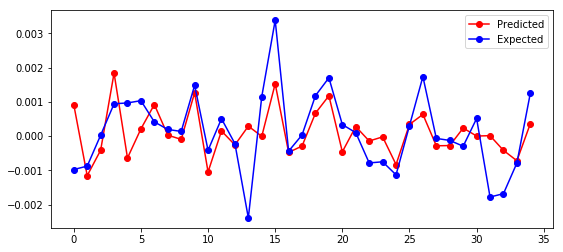

SVR


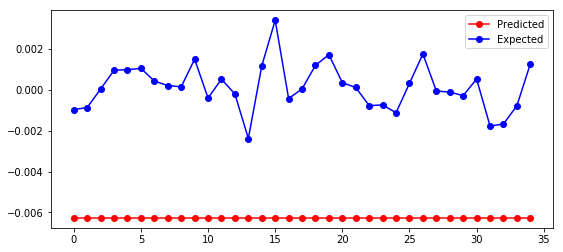

In [49]:
if pricediff:
    Actuals = ['diff USD_JPY_closeMid', 'diff USD_JPY_highMid', 'diff USD_JPY_lowMid']
    Responses = ['future diff close', 'future diff high', 'future diff low']

else:
    Actuals = ['USD_JPY_closeMid', 'H', 'L']
    Responses = ['future close', 'future high', 'future low']

intercept = True
models = {}
prints = 35

for actual,response in zip(Actuals, Responses):
    df = DF.copy()
    df[response] = df[actual].shift(-1)
    df = df.dropna()
    display(df.head())
    display(df.corr()[[response]].sort_values(response))
    X_train, X_test, y_train, y_test = train_test(df, response, train_size=0.75, time_series=True, scaling=None)
    
    if intercept:
        X_train = sm.add_constant(X_train, prepend=True, has_constant='skip')
        X_test = sm.add_constant(X_test, prepend=True, has_constant='skip')

    lr = linreg(X_train, y_train)
    svr = SVR()
    svr.fit(X_train, y_train) 
    print('MSE')
    MSE = mean_squared_error(y_test, lr.predict(X_test))
    print(MSE)
    models["Linreg_{}".format(actual)] = lr
    models["SVR_{}".format(actual)] = svr
    print(actual)
    plt.figure(figsize=(9,4))
    print('LINREG')
    plt.plot(range(len(y_test[:prints])),lr.predict(X_test[:prints]), color='r', marker='o', label='Predicted')
    plt.plot(range(len(y_test[:prints])),y_test[:prints], color='b', marker='o', label='Expected')
    plt.legend()
    plt.show()
    plt.figure(figsize=(9,4))
    print('SVR')
    plt.plot(range(len(y_test[:prints])),svr.predict(X_test[:prints]), color='r', marker='o', label='Predicted')
    plt.plot(range(len(y_test[:prints])),y_test[:prints], color='b', marker='o', label='Expected')
    plt.legend()
    plt.show()

# Backtesting

In [51]:
model = 'Linreg'

In [52]:
bt = pd.DataFrame()
for actual,response in zip(Actuals, Responses):
    df = DF.copy()
    df[response] = df[actual].shift(-1)
    X_train, X_test, y_train, y_test = train_test(df, response, train_size=0.75, time_series=True, scaling=None)
    if intercept:
        X_train = sm.add_constant(X_train, prepend=True, has_constant='skip')
        X_test = sm.add_constant(X_test, prepend=True, has_constant='skip')
    mod = models['{}_{}'.format(model, actual)]
    bt['Expected ' + actual] = y_test
    bt['Predicted ' + actual] = mod.predict(X_test)

In [53]:
for i in bt.columns:
    bt[i] = np.exp(bt[i])

In [89]:
#for i in bt.columns:
#    bt[i] = round(bt[i], 5)
bt['win high'] = bt['Predicted diff USD_JPY_highMid'] - 0.00025 <= bt['Expected diff USD_JPY_highMid']
bt['win low'] = bt['Predicted diff USD_JPY_lowMid'] + 0.00025 >= bt['Expected diff USD_JPY_lowMid'] 

In [90]:
len(bt[bt['win high']])/len(bt)

0.6190256291849457

In [91]:
len(bt[bt['win low']])/len(bt)

0.5942622950819673

In [ ]:
############################3

In [ ]:
bt['win change high'] = 0
bt.loc[(bt['win high']), 'win change high'] = round(bt['Predicted H'] - 0.02 - bt['Expected diff closeMid'].shift(1), 4)
bt.loc[(bt['win high'] != True), 'win change high'] = round(bt['Expected diff closeMid'].shift(1) - bt['Predicted L'] - 0.02, 4)
bt['win change low'] = 0
bt.loc[(bt['win low']), 'win change low'] = round(bt['Expected diff closeMid'].shift(1) - bt['Predicted L'] + 0.02, 4)
bt.loc[(bt['win low'] != True), 'win change low'] = round(bt['Expected diff closeMid'].shift(1) - bt['Predicted H'] + 0.02, 4)
bt = bt.dropna()

# Trading

In [ ]:
response = oanda.get_history(instrument="USD_JPY", granularity='M5', since='2018-11-01')

a = pd.DataFrame(response['candles'])